# Assignment 4 - NYC CitiBike Usage and Weather

## 1) Region and Domain

Region: New York City

Domain: Weather and Bicycling data

## 2) Research Question

How does weather (specifically temperature) affect ridership of public bike share in New York City?

## 3) Links to Datasets (and explanation for the data)

I'm using two datasets: 1) CitiBike (the NYC Bikeshare) ride history dataset, and 2) weather data for NYC area, both from 2016.

#### CitiBike Data
The first dataset is available at [http://www.nyc.gov/html/dot/html/bicyclists/bikestats.shtml](http://www.nyc.gov/html/dot/html/bicyclists/bikestats.shtml) (the bottom for CitiBike, download all 2016 files). This contains every CitiBike ride and the day/time of the ride along with other data. Since the amount of CitiBike data is quite large and loading it all into Pandas dataframes is very wasteful (it consumes nearly all 16GB of my laptop's memory!), I've pre-processed the data a bit using Linux command-line tools. I've done the following:
* removed headers
* taken only the first two columns (trip duration and the start date/time)
* appended all monthly files into two yearly files (necessary because, annoyingly, the date formats are different and it's orders of magnitude faster to parse dates if you know the format ahead of time)

```
cat 20160*citi*.csv | grep -v -i 'duration' | cut -d',' -f1-2 > citibike_01-09-2016_trip_duration_start.csv
cat 20161*citi*.csv | grep -v -i 'duration' | cut -d',' -f1-2 > citibike_10-12-2016_trip_duration_start.csv
```

#### NYC Weather Data
The second file is a file with daily weather data for the year of 2016, downloaded from [ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/2016.csv.gz](ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/2016.csv.gz). A description of the data is available [here](ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/readme.txt). We are only interested in NYC weather data, and from [this](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt) stations file we can see that New York City has a line
```
USW00094728  40.7789  -73.9692   39.6 NY NEW YORK CNTRL PK TWR              HCN 72506
```

So I've filtered the 2016.csv.gz file prior to loading it into Pandas to reduce memory use (`grep 'USW00094728' 2016.csv` did the trick). Note that according to [this readme on daily weather data](ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt), temperatures are reported in tenths of degrees Celcius. Since this data is about NYC and New Yorkers use Fahrenheit, data has been converted.

This project tracks CitiBike usage in terms of total trips as the minimum temperature changes by month.

## 4) Discussion

The visualization tries to show the relationship between weather (specifically temperature) and both ridership and average ride length. The scatterplot maps number of monthly rides in 2016 against each month that year, along with adjusting the color of the dot based on temperature - blue for colder, red for hotter, with a gradient in between. Additionally, the larger the dot, the longer the average ride was that month. You can see, for example, that in December of 2016, the average temperature was very cold and both the number of rides _and_ the length of the rides were very small.  The plot generally illustrates that in colder months, ridership of CitiBike declines. This is clear based on the temperature and the number of rides for a respective month, as well as the length of the ride (size of dot). The length of the ride, however, seems to have a less certain correlation than the number of rides.

In [122]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
import numpy as np
import calendar

%matplotlib notebook

In [2]:
cbd_thru_sept = pd.read_csv('data/citibike_01-09-2016_trip_duration_start.csv')
cbd_thru_sept.columns = ['DurationInSec', 'StartTime']

cbd_oct_to_dec = pd.read_csv('data/citibike_10-12-2016_trip_duration_start.csv')
cbd_oct_to_dec.columns = ['DurationInSec', 'StartTime']

In [3]:
#%timeit pd.to_datetime(cbd.StartTime.head(10000), format="%m/%d/%Y %H:%M:%S")
#%timeit pd.to_datetime(cbd.StartTime.head(10000))
#40 ms ± 3.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
#1.84 s ± 29.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [4]:
cbd_thru_sept['StartDateTime'] = pd.to_datetime(cbd_thru_sept.StartTime, format='%m/%d/%Y %H:%M:%S')
cbd_oct_to_dec['StartDateTime'] = pd.to_datetime(cbd_oct_to_dec.StartTime, format='%Y-%m-%d %H:%M:%S')

In [5]:
cbd = pd.DataFrame()
cbd.colunns = ['DurationInSec', 'StartTime', 'StartDateTime']
cbd = cbd.append([cbd_thru_sept, cbd_oct_to_dec]).reset_index()[['DurationInSec', 'StartTime', 'StartDateTime']]
cbd['Month'] = cbd.StartDateTime.map(lambda x: x.month)

In [6]:
cbd_mean_duration_by_month = cbd.groupby('Month').DurationInSec.mean()

In [7]:
cbd_num_rides_by_month = cbd.groupby('Month').StartTime.count()
cbd_num_rides_by_month

Month
1      509477
2      560874
3      919921
4     1013149
5     1212280
6     1460318
7     1380110
8     1557663
9     1648856
10    1573871
11    1196942
12     812192
Name: StartTime, dtype: int64

In [8]:
weather = pd.read_csv('data/2016_nyc_USW00094728.csv', header=None)
weather.columns = ['Station', 'Date', 'Type', 'Value', '_', '_', '_', '_']
weather = weather[['Date', 'Type', 'Value']]
# Convert numeric-interpreted date column and convert it to an actual date
weather.Date = pd.to_datetime(weather.Date.astype('str'))

In [9]:
min_temps = weather[weather.Type=='TMIN'].reset_index()
max_temps = weather[weather.Type=='TMAX'].reset_index()
# Convert from 10ths of a degree C into F
min_temps.Value = ((min_temps.Value / 10.0) * 9/5) + 32
max_temps.Value = ((max_temps.Value / 10.0) * 9/5) + 32
# Get the month name
min_temps['Month'] = min_temps.Date.map(lambda x: x.month)
max_temps['Month'] = max_temps.Date.map(lambda x: x.month)
#calendar.month_name[x.month]

In [10]:
mean_min_temp_by_month = min_temps.groupby('Month').Value.mean()
mean_min_temp_by_month

Month
1     28.231613
2     30.684138
3     40.378710
4     44.444000
5     54.964516
6     63.554000
7     71.106452
8     71.780000
9     64.562000
10    51.741935
11    42.920000
12    32.870968
Name: Value, dtype: float64

In [11]:
mean_max_temp_by_month = max_temps.groupby('Month').Value.mean()
mean_max_temp_by_month

Month
1     40.808387
2     44.848276
3     57.397419
4     62.234000
5     70.618710
6     80.918000
7     86.255484
8     86.586452
9     79.040000
10    65.776129
11    56.594000
12    43.874194
Name: Value, dtype: float64

In [74]:
all_data_by_month = pd.DataFrame()
all_data_by_month['MinTemp'] = mean_min_temp_by_month
all_data_by_month['MaxTemp'] = mean_max_temp_by_month
all_data_by_month['NumRides'] = cbd_num_rides_by_month
all_data_by_month['RideLengthAvgSec'] = cbd_mean_duration_by_month
all_data_by_month['MonthName'] = all_data_by_month.index.map(lambda x: calendar.month_name[x])
all_data_by_month['MonthNum'] = all_data_by_month.index.map(lambda x: x)
all_data_by_month

,MinTemp,MaxTemp,NumRides,RideLengthAvgSec,MonthName,MonthNum
Month,,,,,,
1,28.231613,40.808387,509477,847.211782,January,1
2,30.684138,44.848276,560874,877.094959,February,2
3,40.378710,57.397419,919921,1019.789868,March,3
4,44.444000,62.234000,1013149,1074.349986,April,4
5,54.964516,70.618710,1212280,1052.514054,May,5
6,63.554000,80.918000,1460318,989.758037,June,6
7,71.106452,86.255484,1380110,1000.327859,July,7
8,71.780000,86.586452,1557663,980.285741,August,8
9,64.562000,79.040000,1648856,947.343280,September,9


In [59]:
plt.style.use('seaborn-colorblind')

<IPython.core.display.Javascript object>


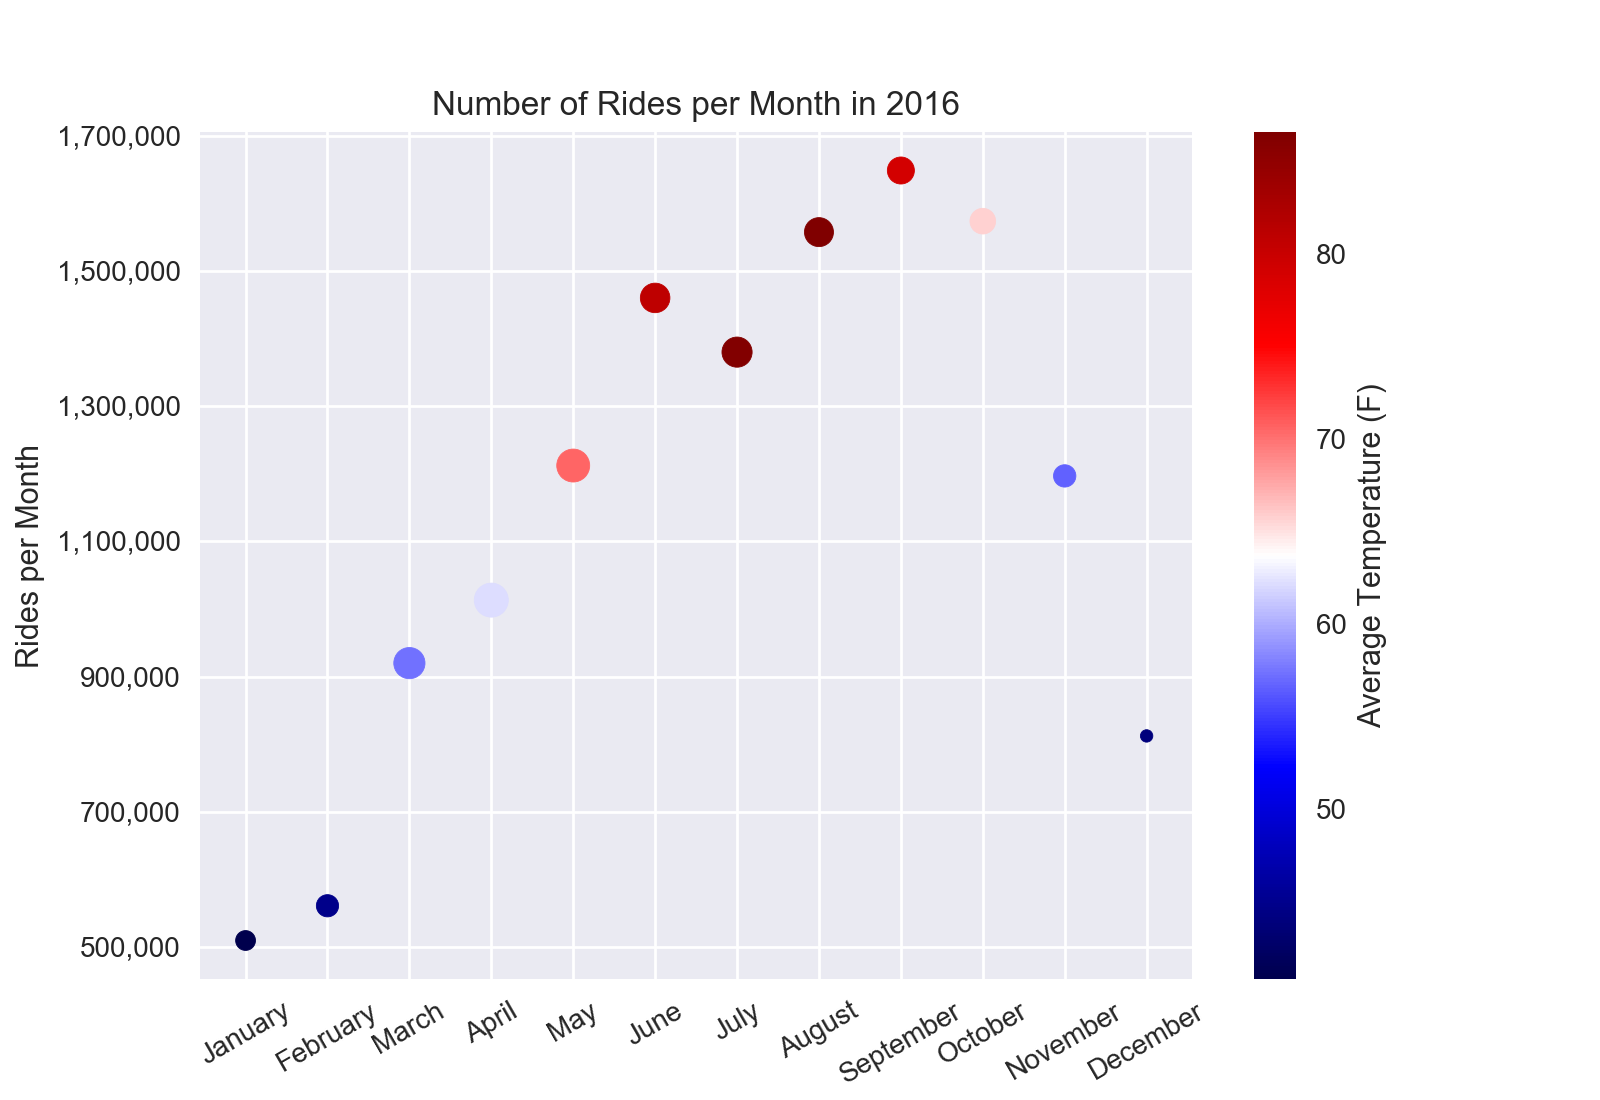

In [121]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as dates
import matplotlib.ticker as ticker

# make the ride length a 2-d array so we can normalize
pixel_size_scaler = MinMaxScaler(feature_range=(20, 150))
# scale the ride length between 20 and 150 so the scatterplot dot sizes change
ride_length_point_size = pixel_size_scaler.fit_transform(
    np.array(all_data_by_month.RideLengthAvgSec).reshape((len(all_data_by_month.RideLengthAvgSec), 1)))

# do the actual plot
ax = all_data_by_month.plot(
    x='MonthNum',
    y='NumRides',
    c='MaxTemp',
    s=ride_length_point_size,
    xticks=all_data_by_month.MonthNum.values,
    kind='scatter',
    colormap='seismic',
    title='Number of Rides per Month in 2016')

# set the ticks for rides per month
ax.yaxis.set_ticks([500000, 700000, 900000, 1100000, 1300000, 1500000, 1700000])
ax.yaxis.set_label_text('Rides per Month')
# Format using commas at thousands to make the Y-axis more readable
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# set the tick labels to be the names of Months
ax.xaxis.set_ticklabels(all_data_by_month.MonthName.values)
ax.xaxis.set_label_text('')
# rotate the month names a bit so it's more readable
labels = ax.get_xticklabels()
plt.setp(labels, rotation=30);

# set the color bar label
f = plt.gcf()
cax = f.get_axes()[1]
cax.set_ylabel('Average Temperature (F)');